In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1])
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1])            

Found and verified. ./train.zip
Found and verified. ./test.zip


In [2]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file succeed. ./train.zip
Unzip file succeed. ./test.zip


In [1]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map
'''
rebuild_dir(dat_dir)
rebuild_dir(cate_dat_dir)
dog_counts = rearrange_data("dog")
cat_counts = rearrange_data("cat")
image_properties_dog = get_image_properties("dog")
image_properties_cat = get_image_properties("cat")
'''

'\nrebuild_dir(dat_dir)\nrebuild_dir(cate_dat_dir)\ndog_counts = rearrange_data("dog")\ncat_counts = rearrange_data("cat")\nimage_properties_dog = get_image_properties("dog")\nimage_properties_cat = get_image_properties("cat")\n'


dogs count : [12500]. cats count:[12500]

dogs group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64

cats group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64


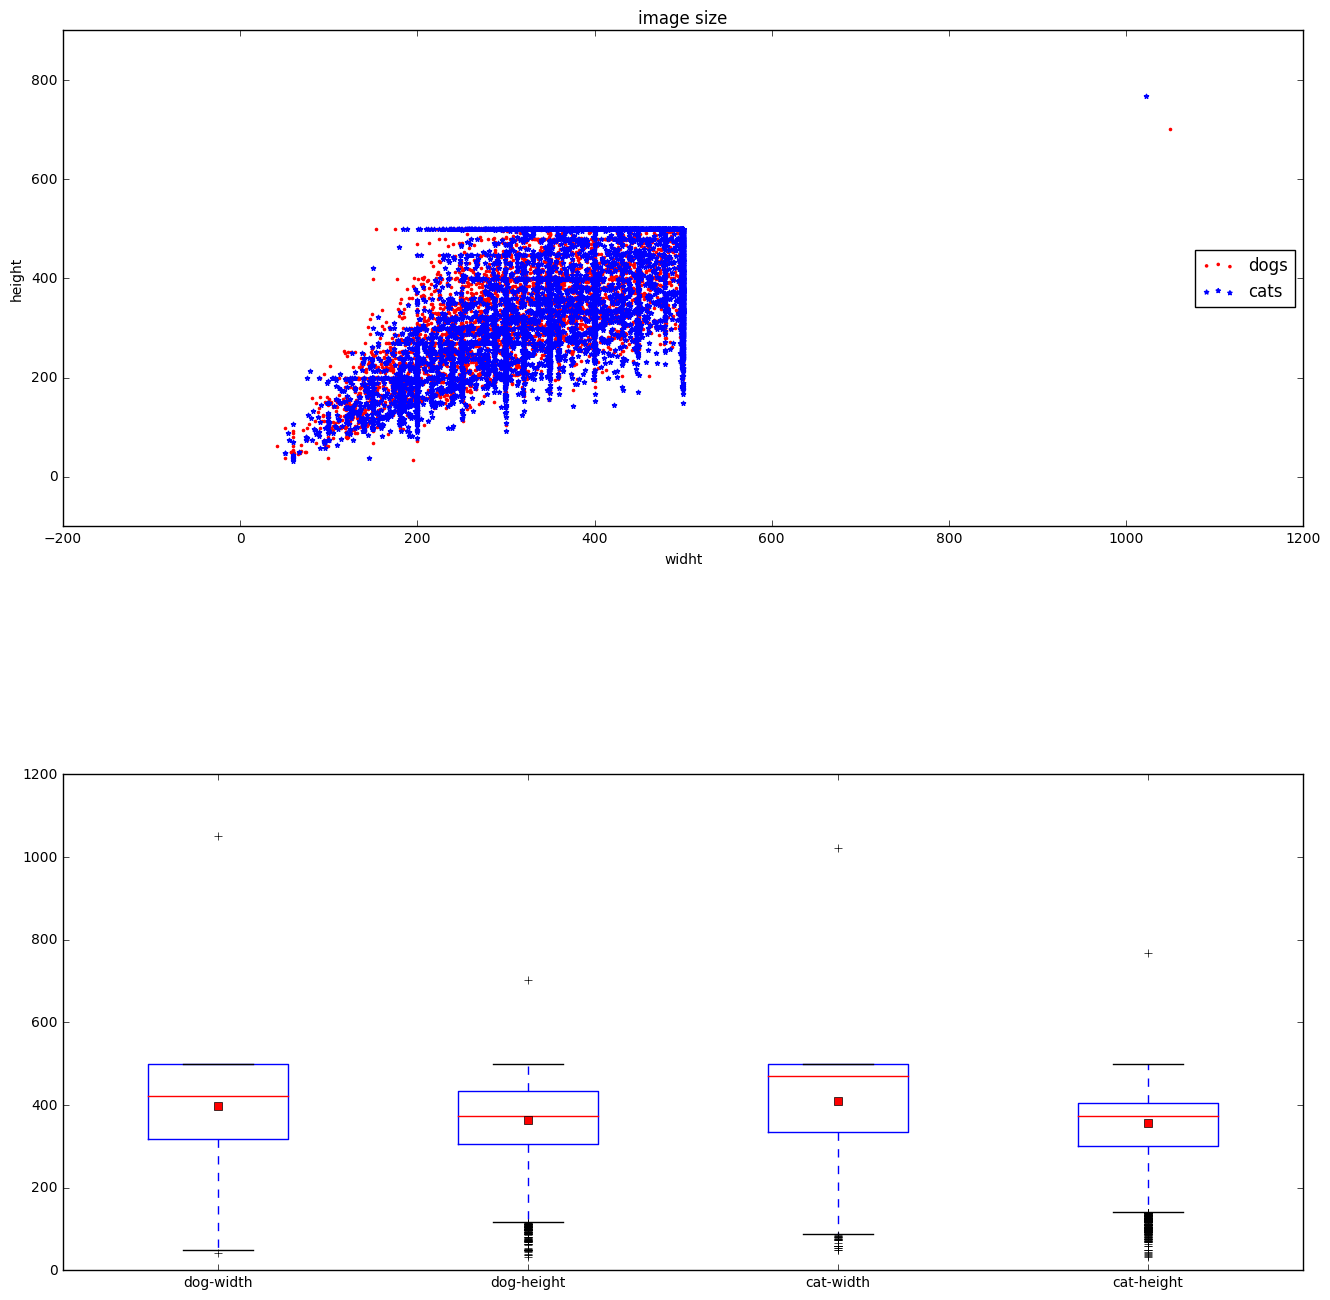


dogs width max/min:
               format mode width height
dog.2317.jpg    JPEG  RGB  1050    702
dog.10733.jpg   JPEG  RGB    42     62

dogs height max/min:
              format mode width height
dog.2317.jpg   JPEG  RGB  1050    702
dog.4367.jpg   JPEG  RGB   195     33

cats width max/mai:
               format mode width height
cat.835.jpg     JPEG  RGB  1023    768
cat.10392.jpg   JPEG  RGB    50     49

cats height max/min:
              format mode width height
cat.835.jpg    JPEG  RGB  1023    768
cat.6402.jpg   JPEG  RGB    60     32


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

columns = ['format', 'mode', 'width', 'height']

df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs count : [{}]. cats count:[{}]".format(dog_counts, cat_counts))

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())


plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

In [2]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None, create_link=False):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name + "/"
    dest_train_dir = train_dat_dir + "/" + category_name + "/"
    dest_valid_dir = valid_dat_dir + "/" + category_name + "/"
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            dest_dir = dest_valid_dir
        else:
            dest_dir = dest_train_dir
        
        if create_link == True:
                os.symlink(source_dir + filenames[i], dest_dir + filenames[i])
        else:
                shutil.copy(source_dir + filenames[i], dest_dir)
                
    return train_size, test_size


Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
547/547 [==============================] - 1129s - loss: 0.6679 - acc: 0.5717 - val_loss: 0.6384 - val_acc: 0.6161
Epoch 2/150
547/547 [==============================] - 1116s - loss: 0.5961 - acc: 0.6693 - val_loss: 0.5279 - val_acc: 0.7412
Epoch 3/150
547/547 [==============================] - 1117s - loss: 0.5471 - acc: 0.7168 - val_loss: 0.5232 - val_acc: 0.7351
Epoch 4/150
547/547 [==============================] - 1117s - loss: 0.5197 - acc: 0.7405 - val_loss: 0.4880 - val_acc: 0.7643
Epoch 5/150
547/547 [==============================] - 1117s - loss: 0.4940 - acc: 0.7608 - val_loss: 0.4780 - val_acc: 0.7695
Epoch 6/150
547/547 [==============================] - 1117s - loss: 0.4697 - acc: 0.7762 - val_loss: 0.4733 - val_acc: 0.7700
Epoch 7/150
547/547 [==============================] - 1118s - loss: 0.4465 - acc: 0.7911 - val_loss: 0.4217 - val_acc: 0.8076
Epoch 8/150
547/547 [=====

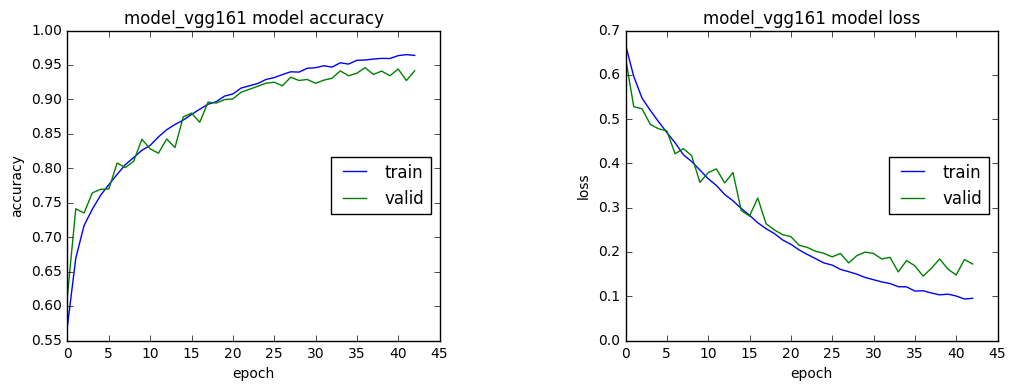

In [3]:
#model_vgg161
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 32
poch_num = 150


name_vgg161 = "model_vgg161"
model_vgg161 = ModelUtil.model_vgg161(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
model_vgg161.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg161, model_name=name_vgg161)
history_vgg161 = ModelUtil.train_data_earlystopping(model_vgg161, model_name=name_vgg161, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg161, model_name=name_vgg161)
with open('model_vgg16_pre_tune2.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune2.history, f)
ModelUtil.save_model(model_vgg161, model_name=name_vgg161)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 351s - loss: 0.6411 - acc: 0.6384 - val_loss: 0.5248 - val_acc: 0.8201
Epoch 2/150
274/274 [==============================] - 351s - loss: 0.5005 - acc: 0.7842 - val_loss: 0.3802 - val_acc: 0.8444
Epoch 3/150
274/274 [==============================] - 351s - loss: 0.4029 - acc: 0.8282 - val_loss: 0.2965 - val_acc: 0.8801
Epoch 4/150
274/274 [==============================] - 350s - loss: 0.3425 - acc: 0.8569 - val_loss: 0.2662 - val_acc: 0.8888
Epoch 5/150
274/274 [==============================] - 351s - loss: 0.3112 - acc: 0.8678 - val_loss: 0.2457 - val_acc: 0.9008
Epoch 6/150
274/274 [==============================] - 351s - loss: 0.2901 - acc: 0.8793 - val_loss: 0.2332 - val_acc: 0.9039
Epoch 7/150
274/274 [==============================] - 351s - loss: 0.2731 - acc: 0.8858 - val_loss: 0.2178 - val_acc: 0.9109
Epoch 8/150
274/274 [============

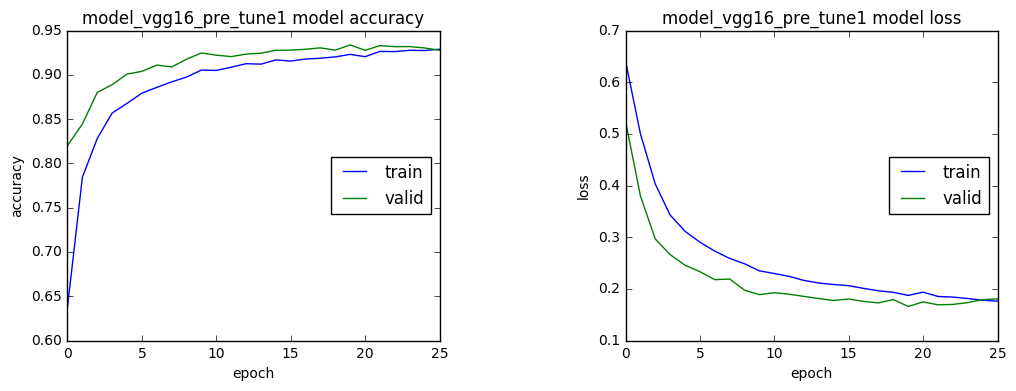

In [6]:
#model_vgg16_pre_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune1 = "model_vgg16_pre_tune1"
model_vgg16_pre_tune1 = ModelUtil.model_vgg16_pre_tune1(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
model_vgg16_pre_tune1.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
history_vgg16_pre_tune1 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
with open('model_vgg16_pre_tune2.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune2.history, f)
ModelUtil.save_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
137/137 [==============================] - 324s - loss: 0.3676 - acc: 0.8343 - val_loss: 0.3674 - val_acc: 0.8897
Epoch 2/150
137/137 [==============================] - 322s - loss: 0.2608 - acc: 0.8885 - val_loss: 0.2717 - val_acc: 0.8900
Epoch 3/150
137/137 [==============================] - 322s - loss: 0.2328 - acc: 0.9002 - val_loss: 0.2877 - val_acc: 0.8760
Epoch 4/150
137/137 [==============================] - 322s - loss: 0.2209 - acc: 0.9056 - val_loss: 0.1770 - val_acc: 0.9304
Epoch 5/150
137/137 [==============================] - 322s - loss: 0.2153 - acc: 0.9083 - val_loss: 0.1923 - val_acc: 0.9205
Epoch 6/150
137/137 [==============================] - 322s - loss: 0.2071 - acc: 0.9124 - val_loss: 0.1873 - val_acc: 0.9225
Epoch 7/150
137/137 [==============================] - 322s - loss: 0.2054 - acc: 0.9142 - val_loss: 0.1797 - val_acc: 0.9259
Epoch 8/150
137/137 [============

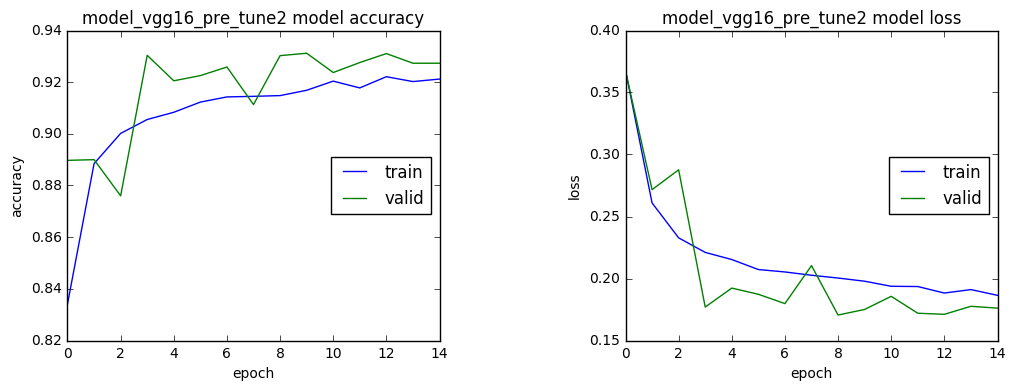

In [10]:
#model_vgg16_pre_tune2
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 128
poch_num = 150


name_vgg16_pre_tune2 = "model_vgg16_pre_tune2"
model_vgg16_pre_tune2 = ModelUtil.model_vgg16_pre_tune2(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
adam = optimizers.Adam(lr=1e-3)
model_vgg16_pre_tune2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
history_vgg16_pre_tune2 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
with open('model_vgg16_pre_tune2.pickle', 'wb') as f:
    pickle.dump(history_vgg16_pre_tune2.history, f)
ModelUtil.save_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/150
313/313 [==============================] - 146s - loss: 0.8489 - acc: 0.5592 - val_loss: 0.7025 - val_acc: 0.6252
Epoch 2/150
313/313 [==============================] - 140s - loss: 0.6655 - acc: 0.6422 - val_loss: 0.6040 - val_acc: 0.7012
Epoch 3/150
313/313 [==============================] - 142s - loss: 0.5994 - acc: 0.6970 - val_loss: 0.5320 - val_acc: 0.7460
Epoch 4/150
313/313 [==============================] - 142s - loss: 0.5323 - acc: 0.7545 - val_loss: 0.5126 - val_acc: 0.7634
Epoch 5/150
313/313 [==============================] - 143s - loss: 0.4780 - acc: 0.7871 - val_loss: 0.4304 - val_acc: 0.8162
Epoch 6/150
313/313 [==============================] - 143s - loss: 0.4365 - acc: 0.8096 - val_loss: 0.3890 - val_acc: 0.8316
Epoch 7/150
313/313 [==============================] - 143s - loss: 0.4087 - acc: 0.8253 - val_loss: 0.3721 - val_acc: 0.8474
Epoch 8/150
313/313 [============

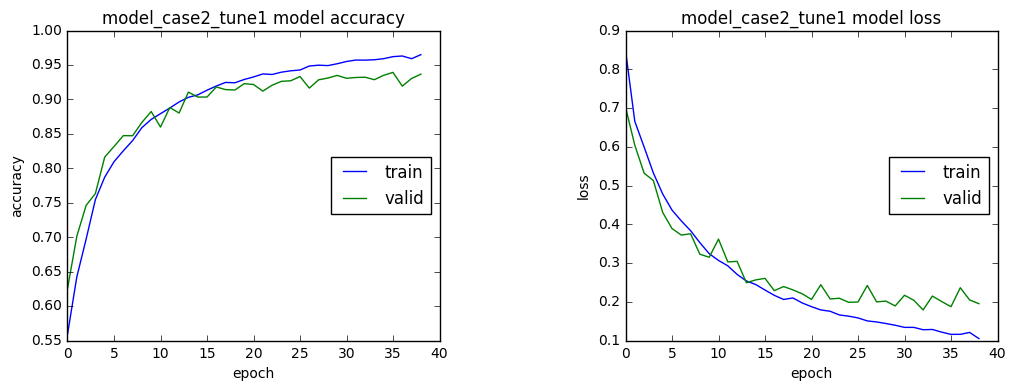

Found 12500 images belonging to 1 classes.


KeyboardInterrupt: 

In [13]:
#model_case2_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train1"
valid_dat_dir = dat_dir + "/valid1"
categories = ["cat", "dog"]
rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.2, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.2, 1234, False)
total_train_size = 20000 #dog_train_size + cat_train_size
total_valid_size = 5000 #dog_test_size + cat_test_size
'''
dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)
total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
'''

image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150

name_case2_tune1 = "model_case2_tune1"
model_case2_tune1 = ModelUtil.model_mycase2_tune1(image_width, image_height)
adam = optimizers.Adam(lr=0.00001)
#rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune1, model_name=name_case2_tune1)
history_case2_tune1 = ModelUtil.train_data_earlystopping(model_case2_tune1, model_name=name_case2_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                         train_dir=train_dat_dir, train_size=total_train_size,
                         valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2_tune1, model_name=name_case2_tune1)
ModelUtil.predict_data(model_case2_tune1, model_name=name_case2_tune1, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2_tune1, model_name=name_case2_tune1)

In [36]:
#model_pre_tune3

import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


import pickle

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 2


name_pre_tune3 = "model_pre_tune3"
model_pre_tune3 = ModelUtil.model_pre_tune3(image_width, image_height)
sgd = optimizers.SGD(lr=1e-4, momentum=0.9)
adam = optimizers.Adam(lr=1e-3)

model_pre_tune3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_pre_tune3, model_name=name_pre_tune3)
history_pre_tune3 = ModelUtil.train_data_earlystopping(model_pre_tune3, model_name=name_pre_tune3, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
with open('model_pre_tune3.pickle', 'wb') as f:
    pickle.dump(history_pre_tune3.history, f)
ModelUtil.visualize_history(history_pre_tune3, model_name=name_pre_tune3)

ModelUtil.predict_small_data(model_pre_tune3, "./visual_images", image_width, image_height, perbatch)
ModelUtil.save_model(model_pre_tune3, model_name=name_pre_tune3)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2D (None, 230, 230, 3)   0           input_18[0][0]                   
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_18[0][0]          
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

KeyboardInterrupt: 

In [41]:
import ModelUtil
import importlib
importlib.reload(ModelUtil)
scores = ModelUtil.evaluate_model(model_pre_tune3,epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size)
print(scores)


Found 17500 images belonging to 2 classes.
[0.42723789513111116, 0.79531249999999998]


In [26]:
from keras.models import model_from_json
import ModelUtil
import importlib
importlib.reload(ModelUtil)

image_width = 224
image_height = 224
perbatch = 64

chosed_model_name="model_pre_tune3"
chosed_model = model_from_json(open(chosed_model_name + '.json').read())
chosed_model.load_weights(chosed_model_name + '.h5')

ModelUtil.predict_data(chosed_model, model_name=chosed_model_name, 
                image_size=(image_width, image_height), 
                num_perbatch=perbatch)

OSError: Unable to open file (Unable to open file: name = 'model_pre_tune3.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [30]:
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from quiver_engine import server
from keras import applications

image_width = 224
image_height = 224
perbatch = 64


model_name="model_pre_tune3"
model = model_from_json(open(model_name + '.json').read())
model.load_weights(model_name + '_top.h5')
for layer in model.layers:
    layer.trainable = False
#model.summary()

from keras import backend as K

inp = model.input  
outputs = [layer.output for layer in model.layers[-3:]]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
img_path = './visual_images/test/cat.51.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

layer_outs = functor([x, 0.])
print(layer_outs)
print(y_classes)
#preds = model.predict(x)

'''
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
img_path = './visual_images/test/cat.51.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


from keras.layers import *
initial_model = applications.ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_width,image_height,3)))
    
x = initial_model.output
x = GlobalAveragePooling2D()(x)
    #x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) 
model = Model(inputs=initial_model.input, outputs=predictions)
'''

#server.launch(model,  classes=['cat','dog'], input_folder="./visual_images/test", port=7000)

[array([[ 1.34112203,  1.27761042,  0.        , ...,  0.88032359,
         5.59820223,  1.06639194]], dtype=float32), array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.21414042e-38,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.06510849e-30,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00

NameError: name 'y_classes' is not defined